# Locating bad datapoints

In this notebook we cover:
* Approaches for **locating outliers**
* Replacing missing data with **NaN** (how to do it; what choices we need to make)



As we have seen, if a dataset contains outliers this can distort the calculated values of statistics such as the mean and standard deviation

In real datasets, outliers are common, often arising from one of the following causes:

* Real but unusual values 
    * many basketball players are outliers in terms of height
* Noise in a data recording system 
    * in brain imaging data, motion artefacts generated by head movements (MRI) or blinks (EEG) are much larger than the real brain activity we are trying to record
* Data entry error 
    * a human types the wrong number, uses the wrong units or misplaces a decimal point
* Dummy values
    * In some datasets an 'obvioulsy wrong' numerical value, such as 9999, is used to indicate a missing datapoint

Identifying and removing outliers and bad data points is a crucial step in the process of preparing our data for analysis, sometimes called *data wrangling*


## Set up Python Libraries

As usual you will need to run this code block to import the relevant Python libraries

In [1]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Import a dataset to work with

We  will work with the file heartAttack.csv, which contains data on several thousand patients admitted to hospital in New York City on a single day, diagnosed with a heart attack.

From this dataset we can explore how demographic and disease factors affect the duration of stay in hospital and the  dollar cost of treatment.

The dataset are downloaaded with thanks (and with slight modifications for teaching purposes) from the website <a href="https://dasl.datadescription.com/">DASL</a> (Data and Story Library)

In [2]:
hospital=pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/heartAttack.csv')
display(hospital)

,CHARGES,LOS,AGE,SEX,DRG,DIED
0,4752.00,10,79.0,F,122.0,0.0
1,3941.00,6,34.0,F,122.0,0.0
2,3657.00,5,76.0,F,122.0,0.0
3,1481.00,2,80.0,F,122.0,0.0
4,1681.00,1,55.0,M,122.0,0.0
...,...,...,...,...,...,...
12839,22603.57,14,79.0,F,121.0,0.0
12840,NaN,7,91.0,F,121.0,0.0
12841,14359.14,9,79.0,F,121.0,0.0
12842,12986.00,5,70.0,M,121.0,0.0


The columns of the dataframe are:
    
* CHARGES - dollar cost fo treatment
* LOS - length of hospital stay in days
* AGE - patient age in years
* SEX - patient's biological sex
* DRG - a code noted on dischaarge fromm hospital
* DIED - 1 if the patient died, 0 if they survived

## Finding outliers

When working with a new dataset it is always necessary to check for missing data and outliers. There are a couple of ways of checking:


### Check min/max values are plausible

- `df.describe()`

Often if there is an outlier or misrecorded data point, the outlier will be the minimum or maximum value in a dataset:

* If the decimal point is misplaced we get a very large (or small value) - eg a person's height could easily be misrecorded as 1765 cm (over 17 metres!) instead of 176.5 cm
* If the wrong units are used we could get a very large or small value - eg a person's height is recorded as 1.756 (m) when it should have been recorded as 176.5 (cm) 
* sometimes 'dummy' values are used as placeholders for missing data - often the duymmy value is `NaN` but sometimes an obviously-wrong numerical value (such as 99, 999 or 9999) is used, which will generally be aa large number compared to real numerical values.

Therefore, running `df.describe()` and checking the min and max values for each datapoint is a good first step

Let's try it with our hospital dataset:

In [3]:
hospital.describe()

,CHARGES,LOS,AGE,DRG,DIED
count,12145.000000,12844.000000,12842.000000,12841.000000,12841.000000
mean,9879.087615,8.345765,67.116726,121.690523,0.109805
std,6558.399650,88.309430,88.925998,0.658289,0.312658
min,3.000000,0.000000,20.000000,121.000000,0.000000
25%,5422.200000,4.000000,57.000000,121.000000,0.000000
50%,8445.000000,7.000000,67.000000,122.000000,0.000000
75%,12569.040000,10.000000,77.000000,122.000000,0.000000
max,47910.120000,9999.000000,9999.000000,123.000000,1.000000


I can see something suspicious!

* The max values for length of stay (<tt>LOS</tt>) is 9999 days (about 3 years)
* The max value for Age (<tt>LOS</tt>) is 9999 years

It looks like <tt>9999</tt> may have been used as a dummy value for missing data.

### Plot the data

What about the column <tt>CHARGES</tt>? 

* The maximum value of \$48910.12 is horrifyingly high, but as we are (hopefully) unfamiliar with medical billing, it is hard to say if this is an outlier
* The minimum value of \$3 is also suspect, did they just give the patient a paracetooml and send them on their way?!

To get a clearer picture we can plot the distribution of <tt>CHARGES</tt>:



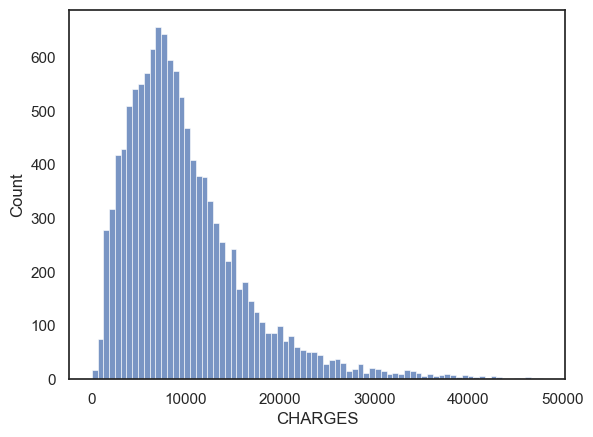

In [4]:
sns.histplot(data=hospital, x='CHARGES')
plt.show()

Hm, the distribution of costs is skewed, but the maximum value of \$49000 dollars appears to just be the 'tip of the tail' rather than an actual outlier.

#### How will I know if it is a real outlier?

Sometimes it is obvious - look what happens when we plot the distribution of Length of Stay:

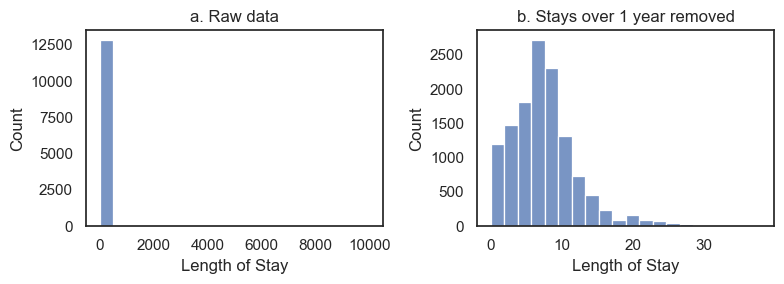

In [5]:
plt.figure(figsize=(8,3)) # when I first plotted this it looked a bit squashed so I adjusted the figsize

plt.subplot(1,2,1)
sns.histplot(data=hospital, x='LOS', bins=20)
plt.title('a. Raw data')
plt.xlabel('Length of Stay')

plt.subplot(1,2,2)
sns.histplot(data=hospital.query('LOS < 365'), x='LOS', bins=20)
plt.title('b. Stays over 1 year removed')
plt.xlabel('Length of Stay')

plt.tight_layout()
plt.show()

**Panel a** (raw data) tells usthat the values of length of stay extend up to 10000 
* we can't see the bar at 9999 because only a few datapoints have this value compared to 12500 real datapoints, 
* however, we can see that the axis has autoscaled to accommodate values up to 10000
    * the autoscaling is a hint to use as data scientists that there are outlier values. 
    * It's not a good way to present this fact to a client unfamiliar with `Seaborn`'s quirks!
    * this is the kind of plot you make for yourself, not something you put in a report

In **panel b**, I excluded stays over one year - I chose the cut-off value of 1-year arbitrarily. However, I can see from panel b that no values even approach 1 year, so I am happy with my choice of cut-off retained all real values of length of stay and removed the outliers

### Use a 'standard' cut-off

Sometimes it's not so clear where the boundary is between real data and outliers.

In this case, researchers sometimes define outliers as those lying more than 3 standard deviations from the mean.

* Under the normal distribution, values 3 standard deviations from the mean occur about 1/1000 of the time so the 3xSD cut-off should exclude relatively few real values
* If your data are not Normally distributed, this cutoff may be less suitable. 
* Don't worry if you don't know what normal distribution is yet - this will make sense when you come back and revise!


We can calculate the 3SD cutoff for <tt>CHARGES</tt>:

In [6]:
m = hospital.CHARGES.mean()
s = hospital.CHARGES.std()

cutoff = [m-3*s, m+3*s]

display(cutoff)

[-9796.111336261178, 29554.286565573653]

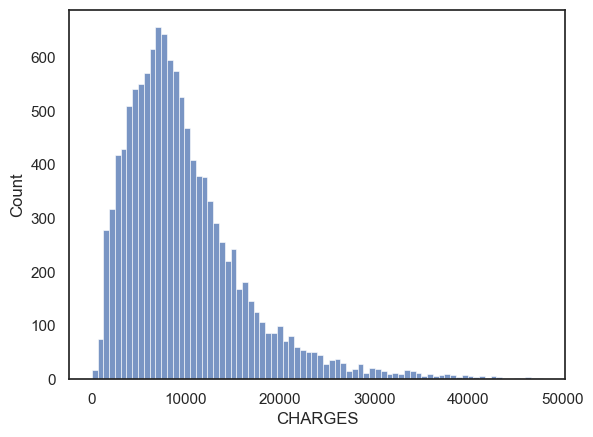

In [7]:
# re-plot the hisptogram so we can see where the 3SD cut-off falls
sns.histplot(data=hospital, x='CHARGES')
plt.show()

By this criterion, charges below -9800 dollars and above 30000 are considered outliers.

* These are not good cut-off values!
    * Looking again at the histogram of CHARGES above, 30001 dollars seems no less plausible than 29999
    * -9800 dollars is an impossible value so wouldn't exclude any cases anyway!

The 3SD approach didn't work so well in this case because the data distribution is very skewed, so high positive values are actually quite plausible, whilst the natural cut-off value for low <tt>CHARGES</tt> (zero dollars) is not so far from the mean.